In [76]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import pseudoEmpiricalData
import featureSelectRegression
import CombinedFC.CombinedFCToolBox as cfc
import ActflowToolbox as actflow
import PCalg_wrapper

In [74]:
# import the graphModel module from the CombinedFCToolBox
from CombinedFC.CombinedFCToolBox import graphModel

#number of repetitions of the simulation
num_repetitions = 5

# graphical model parameters
num_nodes = 200
density_edges = 0.05
model_type = 'ErdosRenyi'
#round and make an int (multiply by 2 because the model reduce the original density by half)
num_edges = np.around(density_edges*2*(num_nodes*(num_nodes-1)/2)).astype(int)
# number of datapoints for the simulated data
sample_size = 1000
# coefficients for the weights of the connectivity matrix
min_coeff = 0.1
max_coeff = 0.6
# percentage of negative coefficients
p_neg = 0.10

#number of tasks to simulate
num_tasks = 1
#percentage of nodes directly affected by the task: T --> node_i
p_nodes = 0.10
#number of nodes directly affected by the task for this model
Nt = np.around(p_nodes*num_nodes).astype(int)



#PC 
m_PC =  np.zeros((num_nodes,num_nodes,num_repetitions))
pred_act_PC = np.zeros((num_nodes,num_tasks,num_repetitions))
time_PC = np.zeros((num_repetitions,))
#PC_adjacencies
m_PCadj =  np.zeros((num_nodes,num_nodes,num_repetitions))
pred_act_PCadj = np.zeros((num_nodes,num_tasks,num_repetitions))

print('Main parameters of the simulations')
print(f'- number of simulations: {num_repetitions}')
print(f'- number of nodes: {num_nodes}')
print(f'- connectivity density: {density_edges*100}%')
print(f'- edge coefficient range (-{max_coeff},-{min_coeff}]U({min_coeff},{max_coeff}]')
print(f'- percentage of negative edges: {p_neg*100}%')
print(f'- tasks simulated: {num_tasks}')
print(f'- precentage of nodes directly affected by the task: {p_nodes*100}%')
print(f'- number of datapoints: {sample_size}')

Main parameters of the simulations
- number of simulations: 5
- number of nodes: 200
- connectivity density: 5.0%
- edge coefficient range (-0.6,-0.1]U(0.1,0.6]
- percentage of negative edges: 10.0%
- tasks simulated: 1
- precentage of nodes directly affected by the task: 10.0%
- number of datapoints: 1000


### simulate data: resting-state, task-state and actual task activations NEED TO UPDATE WITH AMAREL VERSION

In [79]:
# simulate data: resting-state, task-state and actual task activations

#initialize vectors to save true connectivity models and pseudoempirical data
#one resting-state session for each repetition
X_rest = np.empty((num_nodes,sample_size,num_repetitions))
W_rest = np.empty((num_nodes,num_nodes,num_repetitions))
# task state data has the additional dimension of number of tasks
# need to add 1 for the task connectivity vector and task variable data
X_task = np.empty((num_nodes+1,sample_size,num_tasks,num_repetitions))
W_task = np.empty((num_nodes+1,num_nodes+1,num_tasks,num_repetitions))
#actual activations
actual_act = np.zeros((num_nodes,num_tasks,num_repetitions))


for rep in range(num_repetitions):
    #generate the random connectivity model, using the model_type graph model defined above
    M = graphModel.graphModel(model_type, num_edges, num_nodes)

    # 1. Simulate resting-state connectivity and pseudo-empirical data
    # randomly choose a subject from which to sample the data
    #subj_data = np.random.choice(num_subjs,1,replace=True)[0]
    # choose subject data, only from the resting-state run 1: rfMRI_REST1_RL
    #data_hcp = rest_data[:,0:1195,subj_data].T
    data_hcp = np.random.normal(5,10,(1195,360))
    #simulate resting state data X and connectivity matrix W, using the pseudoEmpirical_data function
    X_rest[:,:,rep], W_rest[:,:,rep] = pseudoEmpiricalData.pseudoEmpiricalData(data = data_hcp, 
                                                               model = M, 
                                                               sample_size = sample_size,
                                                               weights_given = False, 
                                                               min_coeff = min_coeff, 
                                                               max_coeff = max_coeff, 
                                                               p_neg = p_neg)
    
    
    # 2. Simulate task-state connectivity
    for j in range(num_tasks):
        # initialize the new task matrix coefficents with a copy of the rest network
        M_task = W_rest[:,:,rep].copy()
        # compute the number of edges of the task connectivity matrix
        num_edges_task = np.sum(M_task != 0) 
        # define the task network based on the resting-state network
        # with some random variance added to the coefficients.
        # add some variability to the coefficients so they do not end up being exactly the same as W_rest
        # by summing or subtracting one standard deviation to the coefficient, or doing nothing.
        std_coeff = np.std(M_task[M_task > 0].flatten())
        # make a vector to randomly decide if std_coeff should be added, subtracted or do nothing
        aux_vec = np.random.choice([+std_coeff,-std_coeff,0],size=(1,num_edges_task))
        # create a new vector with the modfied values
        task_weights = M_task[M_task.nonzero()] + aux_vec
        # assign the new values to their position in M_task
        M_task[M_task.nonzero()] =  task_weights
        
        # 3. Add the Task connectivity vector: which nodes are affected by the task variable
        # sample Nt nodes from a num_nodes elements vector, without replacement to avoid choosing a node more than once
        task_nodes = np.random.choice(np.arange(num_nodes),size=[1,Nt],replace=False)
        # build the Task connectivity vector T
        T = np.zeros((num_nodes,1))
        # and assign a task-coefficient to the nodes affected by the task
        T[task_nodes,0] = np.random.uniform(min_coeff,max_coeff, size=(1,Nt))
        # add the T vector to the nodes connectivity matrix M_task
        M_task = np.concatenate((M_task,T),axis=1)
        # add a last row of zeros to make the matrix square
        pad = np.zeros((1,num_nodes+1))
        M_task = np.concatenate((M_task,pad), axis=0)
        
        #4. Create pseudo-empirical task-state data
        #choose subject data, only from the resting-state run 1: rfMRI_REST1_RL
        #data_hcp = rest_data[:,0:1195,subj_data].T
        #simulate task data X and task connectivity matrix W, using the pseudo_data function
        X_task[:,:,j,rep], W_task[:,:,j,rep] = pseudoEmpiricalData.pseudoEmpiricalData(data = data_hcp, 
                                                                   model = M_task, 
                                                                   sample_size = sample_size, 
                                                                   weights_given = True)
        
        
        #5. compute the task activations using a GLM
        data = X_task[:,:,j,rep].copy() #reshape to [datapoints x nodes]
        for i in range(num_nodes):
            #regress each node onto the task: task causal effect
            #use reshape to convert 1D to proper 2D arrays for linear regression call
            y = np.reshape(data[i,:],(-1,1))
            #the task variable data is the last element of the data = X_task
            task = np.reshape(data[-1,:],(-1,1))
            #use the combinedFC toolbox function for regression
            #no significance test threshold, use all the values.
            b = cfc.simpleRegressionSig(y, task, sigTest = False)
            # save the actual activations values [nodes x task x repetition]
            actual_act[i,j,rep] = b
            
print('Resting state data (X_rest) and actual activations (actual_act) created')
print('the true resting-state network models are in W_rest')
print(f'for {num_tasks} task(s) and {num_repetitions} simulations')

Resting state data (X_rest) and actual activations (actual_act) created
the true resting-state network models are in W_rest
for 5 simulations, and 1 task(s)


In [80]:
%%time
# correlation analysis of the resting-state data X_rest using combinedFC toolbox
m_corr = np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_corr = np.empty((num_nodes,num_tasks,num_repetitions))
time_corr = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    m_corr[:,:,rep] = cfc.correlationSig(X_rest[:,:,rep].T, alpha = 0.01)
    #activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_corr[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_corr[:,:,rep])
    #save running time
    time_corr[rep] = time.time() - start

print('Correlation FC matrices and activity flow predictions computed')
print(f'for {num_tasks} task(s) and {num_repetitions} simulations')

Correlation FC matrices and activity flow predictions computed
for 5 simulations, and 1 task(s)
CPU times: user 131 ms, sys: 6.14 ms, total: 137 ms
Wall time: 74.8 ms


In [84]:
%%time
#multiple regression analysis of the resting-state data X_rest using combinedFC toolbox
m_mreg = np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_mreg = np.empty((num_nodes,num_tasks,num_repetitions))
time_mreg = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    m_mreg[:,:,rep] = cfc.multipleRegressionSig(X_rest[:,:,rep].T, alpha = 0.10, sigTest = True)
    # activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_mreg[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_mreg[:,:,rep])
    #save running time
    time_mreg[rep] = time.time() - start

print('Multiple regression FC matrices and activity flow predictions computed')
print(f'for {num_tasks} task(s) and {num_repetitions} simulations')

Multiple regression FC matrices and activity flow predictions computed
for 1 task(s) and 5 simulations
CPU times: user 59.2 s, sys: 335 ms, total: 59.5 s
Wall time: 18.5 s


In [83]:
%%time
#combinedFC with feature selection analysis of resting-state data X_rest
m_cfc =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_cfc = np.empty((num_nodes,num_tasks,num_repetitions))
time_cfc = np.empty((num_repetitions,))

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    data = X_rest[:,:,rep].T
    M_aux = cfc.combinedFC(data,
                         methodCondAsso = 'partialCorrelation',
                         alphaCondAsso = 0.01,
                         methodAsso = 'correlation',
                         alphaAsso = 0.10)
    
    m_cfc[:,:,rep] = featureSelectRegression.featureSelectRegression(M_aux, data, typ='symmetric')
    # activity flow calculation using activity flow toolbox    
    for j in range(num_tasks):
        pred_act_cfc[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_cfc[:,:,rep])
    #save running time
    time_cfc[rep] = time.time() - start
    
print('CombinedFC matrices and activity flow predictions computed')
print(f'for {num_tasks} task(s) and {num_repetitions} simulations')

CombinedFC matrices and activity flow predictions computed
for 1 task(s) and 5 simulations
CPU times: user 1.73 s, sys: 20.5 ms, total: 1.75 s
Wall time: 1.05 s


In [85]:
%%time
#PC algorithm FC analysis of resting-state data X_rest
m_PC =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_PC = np.empty((num_nodes,num_tasks,num_repetitions))
time_PC = np.empty((num_repetitions,))
#PC-adjacencies
m_PCadj =  np.empty((num_nodes,num_nodes,num_repetitions))
pred_act_PCadj = np.empty((num_nodes,num_tasks,num_repetitions))

current_dir = os.getcwd()

for rep in range(num_repetitions):
    start = time.time()
    # FC computation
    #temporary save data for PC. The algorithm requires a txt file as input
    data = X_rest[:,:,rep].T
    #reuse the same name to avoid ending up with too many txt files
    inputData = f'{current_dir}/temp/data_temp.txt'
    np.savetxt(inputData, data, fmt='%0.6f', delimiter=',')
    #define output directory, output name and Tetrad path
    outDir = f'{current_dir}/temp'
    outName = 'PCgraph_temp'
    tetrad_path = f'{current_dir}/tetrad_causal-cmd-1.1.3/causal-cmd-1.1.3-jar-with-dependencies.jar'
    #call PC
    PCalg_wrapper.PCalg_run(inputData, outDir, outName, tetrad_path, alpha = 0.01)
    #transform the PC output graph into a numpy array
    PC_graph = PCalg_wrapper.tetrad2matrix(f'{outDir}/{outName}.txt')
    print(f'graph {rep}')
    
    #Use the set of parents as regressors y = bPa(X) + e, to get a weighted directed matrix
    m_PC[:,:,rep] = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='parents')
    #activity flow calculation using activity flow toolbox
    for j in range(num_tasks):
        pred_act_PC[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_PC[:,:,rep])
    time_PC[rep] = time.time() - start

    #Use the adjacencies of the PC results: parents and children: y = bPa(X) + cCh(x),
    m_PCadj[:,:,rep] = featureSelectRegression.featureSelectRegression(PC_graph, data, typ='adjacencies')
    #activity flow calculation using activity flow toolbox
    for j in range(num_tasks): 
        pred_act_PCadj[:,j,rep] = actflow.actflowcalc(actual_act[:,j,rep], m_PCadj[:,:,rep])
        
print('PC and PC-adjacencies matrices and activity flow predictions computed')
print(f'for {num_tasks} task(s) and {num_repetitions} simulations')

graph 0
graph 1
graph 2
graph 3
graph 4
PC and PC-adjacencies matrices and activity flow predictions computed
for 1 task(s) and 5 simulations
CPU times: user 3.04 s, sys: 133 ms, total: 3.17 s
Wall time: 1min 16s


### plot adjacency network recovery results

median precision across 5 repetitions
 correlation   : 0.10965395635882742
 mul.reg       : 0.22835633626097868
 combinedFC    : 0.64296875
 PC-adjacencies: 0.9756944444444444
 PC algorithm  : 0.9756944444444444


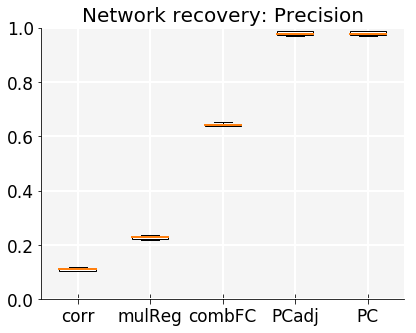

median recall across 5 repetitions
 correlation   : 0.9585741811175337
 mul.reg       : 0.9285714285714286
 combinedFC    : 0.8427991886409736
 PC-adjacencies: 0.579107505070994
 PC algorithm  : 0.579107505070994


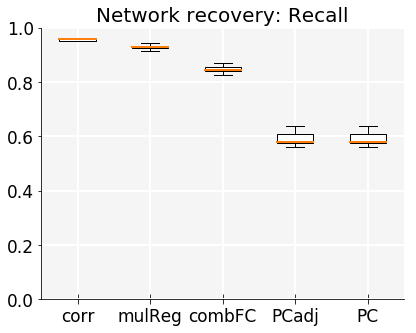

In [87]:
#compute goodness of recovery of true resting-state networks
#use precision and recall as measures. See Figure 2 in paper for details
#use precision and recall functions from the combinedFC toolbox
def accuracy_connectivity(inferred_model, true_model):
    ''''
    both input arrays should be dim:[num_nodes x num_nodes x num_repetitions]
    '''
    #get the number of repetitions. it should be the 3rd dimension of inferred_model
    num_repetitions = inferred_model.shape[2]
    #initialize arrays for results
    precision = np.empty((num_repetitions))
    recall = np.empty((num_repetitions))
    
    for rep in range(num_repetitions):
        # precision = true positives / [true positives + false positives]
        precision[rep] = cfc.precision(inferred_model[:,:,rep], true_model[:,:,rep])
        # recall = true positives / [true positives + false negatives]
        recall[rep] = cfc.recall(inferred_model[:,:,rep], true_model[:,:,rep])
    return precision, recall


#call the accuracy computation function for each FC method tested
#W_rest contains the true resting-state connectivity matrices
corr_precision, corr_recall = accuracy_connectivity(m_corr, W_rest)  
mreg_precision, mreg_recall = accuracy_connectivity(m_mreg, W_rest)  
cfc_precision, cfc_recall = accuracy_connectivity(m_cfc, W_rest)  
PC_precision, PC_recall = accuracy_connectivity(m_PC, W_rest)  
PCadj_precision, PCadj_recall = accuracy_connectivity(m_PCadj,W_rest)  

#consolidate precision results for bar plotting
results_precision = [corr_precision, mreg_precision, cfc_precision, PCadj_precision, PC_precision]
#print median precision across repetitions for each method
print(f'median precision across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_precision)}')
print(f' mul.reg       : {np.median(mreg_precision)}')
print(f' combinedFC    : {np.median(cfc_precision)}')
print(f' PC-adjacencies: {np.median(PCadj_precision)}')
print(f' PC algorithm  : {np.median(PC_precision)}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_precision,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Network recovery: Precision',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
plt.show()
# uncomment to save the plot as a pdf file 
#plt.savefig('SimulationPrecision.pdf',bbox_inches='tight')


#consolidate recall results
results_recall = [corr_recall, mreg_recall, cfc_recall,PCadj_recall,PC_recall]
#print median recall across across repetitions for each method
print(f'median recall across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_recall)}')
print(f' mul.reg       : {np.median(mreg_recall)}')
print(f' combinedFC    : {np.median(cfc_recall)}')
print(f' PC-adjacencies: {np.median(PCadj_recall)}')
print(f' PC algorithm  : {np.median(PC_recall)}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_recall,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Network recovery: Recall',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
plt.show()
# uncomment to save the plot as a pdf file
#plt.savefig('SimulationRecall.pdf',bbox_inches='tight')

### plot activity flow predicted activations

median prediction accuracy (r) across 5 repetitions and 1 task(s)
 correlation   : 0.6839529995434812
 mul.reg       : 0.8251311200448085
 combinedFC    : 0.8825328069942286
 PC-adjacencies: 0.8568773384623135
 PC algorithm  : 0.7502974416509158


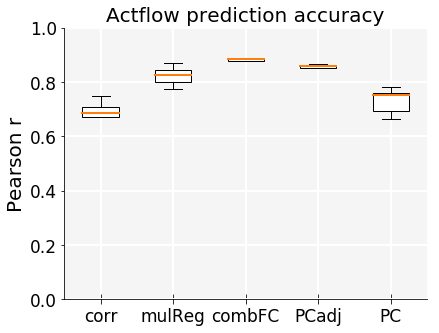

In [88]:
#compute accuracy of activity flow predictions using Pearson correlation.
def accuracy_activations(predicted_act, actual_act):
    '''
    both input arrays should be dim:[num_nodes x num_tasks x num_repetitions]
    '''
    #get the number of repetitions. it should be the 3rd dimension of predicted_act array
    num_repetitions = predicted_act.shape[2]
    num_tasks = predicted_act.shape[1]
    #initialize array for results
    acc = np.empty((num_repetitions,num_tasks))
    #compute correlation between the predicted and actual vector of predictions node-wise
    #independently for each task
    for j in range(num_tasks):
        for rep in range(num_repetitions):
            acc[rep,j] = np.corrcoef(actual_act[:,j,rep],predicted_act[:,j,rep])[0,1]
    return acc


#compute activity flow predictions for each method
#if there are more than 1 task, first average results across task for each subject
corr_acc = np.mean(accuracy_activations(actual_act, pred_act_corr),axis=1)  
mreg_acc = np.mean(accuracy_activations(actual_act, pred_act_mreg),axis=1)
cfc_acc = np.mean(accuracy_activations(actual_act, pred_act_cfc),axis=1)
PCadj_acc = np.mean(accuracy_activations(actual_act, pred_act_PCadj),axis=1) 
PC_acc = np.mean(accuracy_activations(actual_act, pred_act_PC),axis=1)  

#consolidate results for bar plotting
results_prediction = [corr_acc, mreg_acc, cfc_acc, PCadj_acc, PC_acc]
#print median precision across repetitions for each method
print(f'median prediction accuracy (r) across {num_repetitions} repetitions and {num_tasks} task(s)')
print(f' correlation   : {np.median(corr_acc)}')
print(f' mul.reg       : {np.median(mreg_acc)}')
print(f' combinedFC    : {np.median(cfc_acc)}')
print(f' PC-adjacencies: {np.median(PCadj_acc)}')
print(f' PC algorithm  : {np.median(PC_acc)}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_prediction,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Actflow prediction accuracy', fontsize=20)
plt.ylabel('Pearson r',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylim(0,1)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationPredictionAccuracy.pdf',bbox_inches='tight')

### plot number of predictors for activity flow prediction

median number of predictors across 5 repetitions
 correlation   : 90.57
 mul.reg       : 40.31
 combinedFC    : 13.19
 PC-adjacencies: 5.98
 PC algorithm  : 2.99
median indegree of the true networks is: 4.93


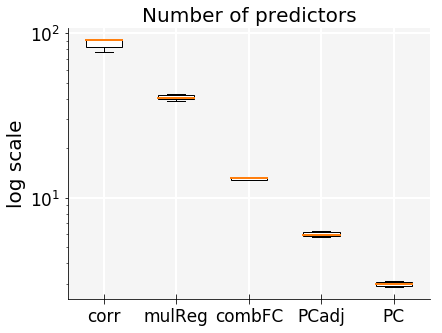

In [89]:
#number of possible predictors (also known as compactness)
#the more predictors (sources), the more complex is the predictive model
def compactness(inferred_model):
    num_repetitions = inferred_model.shape[2]
    compact = np.empty((num_repetitions))
    for rep in range(num_repetitions):
        #average of number of sources across all the nodes in the inferred network
        compact[rep] = np.mean(np.sum(inferred_model[:,:,rep]!=0,axis=1))   
    return compact

#define average number of predictors for each method, for the inferred FC network
corr_compact = compactness(m_corr)
mreg_compact = compactness(m_mreg)
cfc_compact = compactness(m_cfc)
PCadj_compact = compactness(m_PCadj)
PC_compact = compactness(m_PC)
#consolidate results for bar plot
results_compactness = [corr_compact,mreg_compact, cfc_compact, PCadj_compact, PC_compact]
#print median number of predictors across repetitions for each method
print(f'median number of predictors across {num_repetitions} repetitions')
print(f' correlation   : {np.median(corr_compact)}')
print(f' mul.reg       : {np.median(mreg_compact)}')
print(f' combinedFC    : {np.median(cfc_compact)}')
print(f' PC-adjacencies: {np.median(PCadj_compact)}')
print(f' PC algorithm  : {np.median(PC_compact)}')
#the median in-degree of the true models, for comparison
indegree = np.empty((num_repetitions))
for rep in range(num_repetitions):
    #average of number of sources across all the nodes in the inferred network
    indegree[rep] = np.mean(np.sum(W_rest[:,:,rep]!=0,axis=1))
print(f'median indegree of the true networks is: {np.median(indegree)}')   
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_compactness,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Number of predictors',fontsize=20)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.yscale('log')
plt.ylabel('log scale', fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationNumberOfPredictors_log.pdf',bbox_inches='tight')

### plot running time

median running time (sec) across 5 repetitions
 correlation   : 0.015616178512573242
 mul.reg       : 3.2469160556793213
 combinedFC    : 0.17225408554077148
 PC-adjacencies: 11.5913667678833
 PC algorithm  : 11.5913667678833


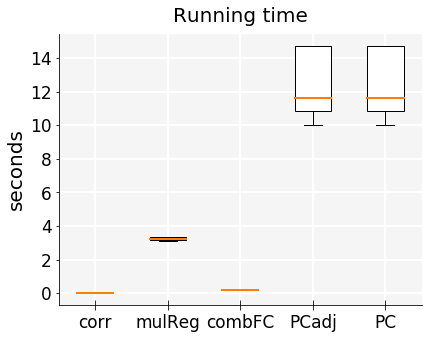

In [90]:
#consolidate results for barplots
results_time = [time_corr, time_mreg, time_cfc,time_PC,time_PC]
#print median running times across repetitions for each method
print(f'median running time (sec) across {num_repetitions} repetitions')
print(f' correlation   : {np.median(time_corr)}')
print(f' mul.reg       : {np.median(time_mreg)}')
print(f' combinedFC    : {np.median(time_cfc)}')
print(f' PC-adjacencies: {np.median(time_PC)}')
print(f' PC algorithm  : {np.median(time_PC)}')
#plot
fig, ax = plt.subplots(figsize=(6.5,5)) 
bp = ax.boxplot(results_time,showfliers=False,patch_artist = True)
for box in bp['boxes']:
    # change fill color
    box.set( facecolor = 'white' )
for median in bp['medians']:
    median.set(linewidth=2)
plt.title('Running time',fontsize=20,y=1.02)
plt.yticks(fontsize=17)
plt.tick_params(axis='x',direction='inout',length=10)
plt.ylabel('seconds',fontsize=20)
plt.xticks(np.arange(1,6,1),('corr','mulReg','combFC','PCadj','PC'),fontsize=17,rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('whitesmoke')
ax.grid(True,color='white',linewidth=2)
# uncomment to save plot as pdf
#plt.savefig('SimulationRunningTimes.pdf', bbox_inches='tight')

### define accuracy of oriented edges for the PC algorithm NEED TO UPDATE WITH THE CYCLIC VERSION

In [91]:
#compute the proportion of correctly oriented edges from the correctly inferred adjacencies (true positives)
def accuracy_orientations(inferred_model, true_model):
    #get the number of repetitions. it should be the 3rd dimension of the inferred_model
    num_repetitions = inferred_model.shape[2]
    correct_orientations = np.empty((num_repetitions))
    for rep in range(num_repetitions):
        correct_orientations[rep] = correctOrientations(inferred_model[:,:,rep], true_model[:,:,rep])
    return correct_orientations

def correctOrientations(inferred_model, true_model):
    #Binarize the inferred connectivity network and the true connectivity network
    inferred_model = (inferred_model != 0).astype(int)
    true_model = (true_model != 0).astype(int)
    num_nodes = inferred_model.shape[0]
    #Number of correctly oriented edges
    c_o = 0   
    for i in range(num_nodes):
        for j in range(num_nodes):
            #check if an edge is present
            if inferred_model[i,j] == 1:
                #check if the orientation is correct
                if inferred_model[i,j] == true_model[i,j]:
                    c_o = c_o + 1 
    #Number of true positive edges
    Tp = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if inferred_model[i,j] == 1:
                if inferred_model[i,j] == true_model[i,j] or inferred_model[i,j] == true_model[j,i]:
                    Tp = Tp + 1             
    #return the proportion of corrently oriented true positive adjacencies.
    return c_o/Tp

#compute the proportion of corrently oriented true positive adjacencies for PC
PC_correct_orientations = accuracy_orientations(m_PC, W_rest)
print('proportion of correctly oriented true positive adjacencies for the PC algorithm')
print(f'median across {num_repetitions} repetitions')
print(f'{np.median(PC_correct_orientations)*100}%')

proportion of correctly oriented true positive adjacencies for the PC algorithm
median across 5 repetitions
78.11387900355872%
